# Computing and plotting 2d spatial point density in R

Author: Max Joseph

It is often useful to quickly compute a measure of event or point density and plot this on a map. 
In this tutorial, we'll demonstrate this using NOAA storm event data across the United States. 

## Objectives

- Compute 2d spatial density of points
- Plot the density surface with a basemap

## Dependencies

- spatstat
- ggmap
- wget

First, we'll grab storm event data for 2015 from NOAA's ftp server:

In [1]:
library(ggmap)
library(spatstat)
library(dplyr)
library(raster)
options(jupyter.plot_mimetypes = 'image/png')

Loading required package: ggplot2
Loading required package: nlme
Loading required package: rpart

spatstat 1.45-2       (nickname: ‘Caretaker Mode’) 
For an introduction to spatstat, type ‘beginner’ 


Attaching package: ‘dplyr’

The following object is masked from ‘package:nlme’:

    collapse

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: sp

Attaching package: ‘raster’

The following object is masked from ‘package:dplyr’:

    select

The following objects are masked from ‘package:spatstat’:

    area, rotate, shift

The following object is masked from ‘package:nlme’:

    getData



In [2]:
# pull data from ftp server
ftp_prefix <- 'ftp://ftp.ncdc.noaa.gov/pub/data/swdi/stormevents/csvfiles/'
data_file <- 'StormEvents_locations-ftp_v1.0_d2015_c20160617.csv'
zipped_filename <- paste0(data_file, ".gz")
fetch_cmd <- paste0("wget ", ftp_prefix, zipped_filename)
system(fetch_cmd)

# unzip
system(paste("gzip -d", zipped_filename)) 

In [3]:
d <- read.csv(data_file)
str(d)

'data.frame':	59269 obs. of  11 variables:
 $ YEARMONTH     : int  201512 201512 201512 201512 201512 201512 201512 201512 201512 201512 ...
 $ EPISODE_ID    : int  101377 101377 101377 101377 101382 100995 100995 100996 100997 100997 ...
 $ EVENT_ID      : int  606556 606556 606560 606560 606604 612634 612635 612627 604364 604364 ...
 $ LOCATION_INDEX: int  1 2 1 2 1 1 1 1 1 2 ...
 $ RANGE         : num  10.42 3.81 0 0 0.9 ...
 $ AZIMUTH       : Factor w/ 16 levels "E","ENE","ESE",..: 15 5 4 4 5 2 15 9 7 4 ...
 $ LOCATION      : Factor w/ 16797 levels "(01R)AFB GNRY RNG AL",..: 15511 11491 11148 14915 7012 13808 13932 4401 16456 16456 ...
 $ LATITUDE      : num  -14.3 -14.3 -14.2 -14.3 32.8 ...
 $ LONGITUDE     : num  -170.8 -170.6 -169.7 -169.5 -93.1 ...
 $ LAT2          : int  -1419464 -1415468 -1412000 -1418000 3247400 4031800 413600 3955200 3027366 3029274 ...
 $ LON2          : int  17050082 17033804 16942000 16930000 933600 12145600 12221600 12054000 9529964 9529502 ...


In [4]:
d <- d %>%
  filter(LATITUDE < 50, LATITUDE > 22, LONGITUDE > -125)

Now, let's compute a spatial density and visualize it. 
Note that there are many ways to compute densities, and if the mechanics of density estimation are important for your application, it is worth investigating packages that specialize in point pattern analysis (e.g., spatstat). 
If on the other hand, you're lookng for a quick and dirty implementation for the purposes of exploratory data analysis, you can also use ggplot's [`stat_density2d`](http://docs.ggplot2.org/0.9.3.1/stat_density2d.html), which uses `MASS::kde2d` on the backend. 

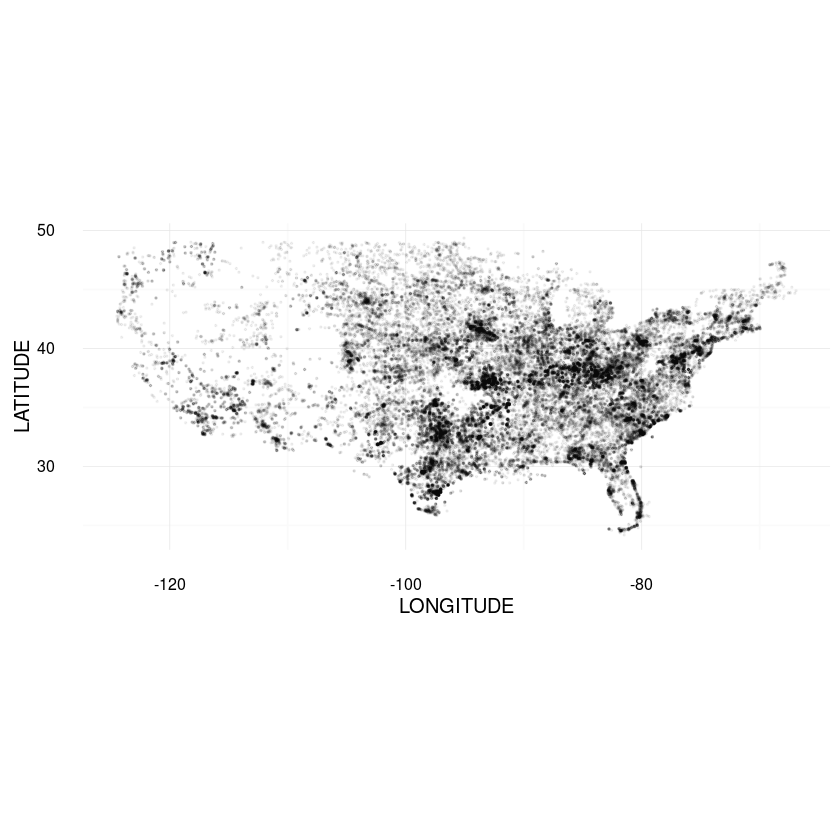

In [5]:
ggplot(d, aes(x = LONGITUDE, y = LATITUDE)) + 
  geom_point(alpha = .05, size = .3) + 
  theme_minimal() +
  coord_equal()

In [6]:
bbox <- make_bbox(LONGITUDE, LATITUDE, data = d, .5)
map <- get_map(location = bbox, maptype = 'satellite')

Warning message:
: bounding box given to google - spatial extent only approximate.converting bounding box to center/zoom specification. (experimental)
Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=36.77,-95.7019&zoom=3&size=640x640&scale=2&maptype=satellite&language=en-EN&sensor=false


Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.
Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Warning message:
: Removed 1 rows containing missing values (geom_rect).

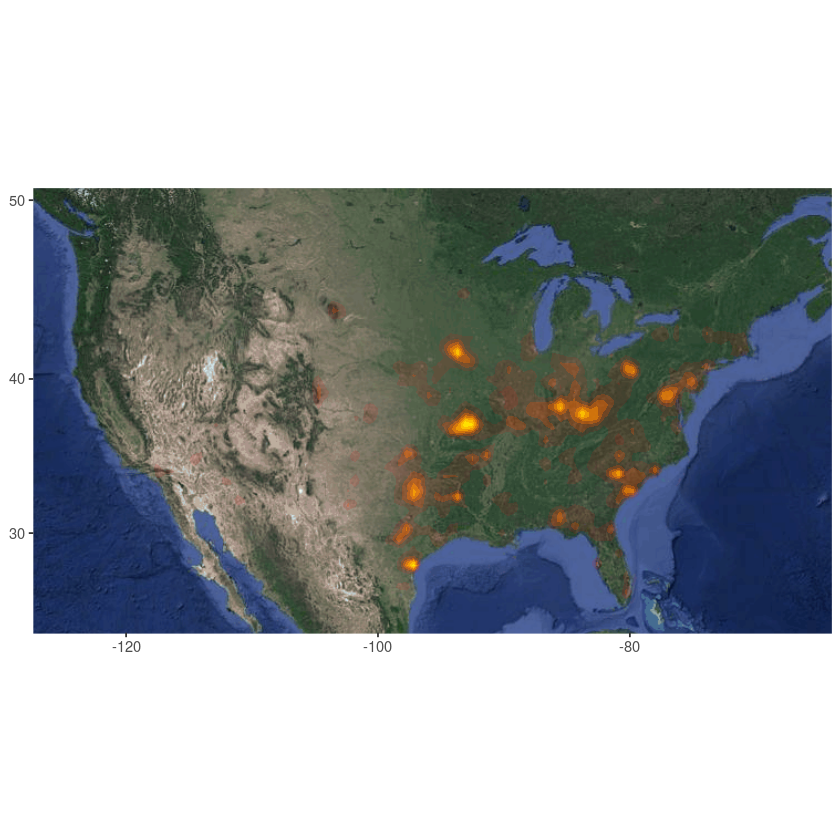

In [7]:
ggmap(map, base_layer = ggplot(aes(x = LONGITUDE, y = LATITUDE), 
                               data = d)) + 
  stat_density2d(aes(fill = ..level.., alpha = ..level..), 
                 geom="polygon", h = 1) + 
  scale_fill_gradient(low="red", high="yellow") + 
  theme(legend.position = 'none', 
        axis.title.x = element_blank(), 
        axis.title.y = element_blank()) + 
  ylim(range(d$LATITUDE)) + 
  xlim(range(d$LONGITUDE))